# 📊 Stock Market Price Prediction and Forecastingnusing LSTM📈


## *Overview*

**Introduction:**

Stock market prediction and forecasting using time series data have become an increasingly popular area of research and application, driven by its significance in investment decisions and risk management. The dynamic nature of stock prices often leads to complex and nonlinear behavior, making traditional methods less effective in capturing these patterns. Machine learning techniques, particularly Long Short-Term Memory (LSTM) models, have emerged as powerful tools for predicting future stock prices and trends.



**Objectives:**
   * Data Acquisition and Preparation: Collect historical stock price data, typically from reliable financial data sources, to serve as input for the     model.
   * Data Analysis and Exploration: Conduct exploratory data analysis (EDA) to understand the stock price behavior, trends, and seasonal patterns.
   * Model Design: Build an LSTM model using the collected data, incorporating preprocessing steps to normalize or standardize data.
   * Model Training and Validation: Train the model on the training dataset and validate its accuracy using evaluation metrics.
   * Forecasting: Use the trained LSTM model to forecast future stock prices and compare these predictions with actual stock prices.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Importing Libraries:

In [2]:
# For time stamps
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

### *Importing Data*

In [3]:
data=pd.read_csv('/kaggle/input/nse-tataglobal/NSE-TATAGLOBAL.csv')
data.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [4]:
# Converting 'Date' column to pandas date time series
data.Date=pd.to_datetime(data.Date)

In [5]:
# Setting Date column as the index
data.set_index('Date',inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2035 entries, 2018-09-28 to 2010-07-21
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Open                  2035 non-null   float64
 1   High                  2035 non-null   float64
 2   Low                   2035 non-null   float64
 3   Last                  2035 non-null   float64
 4   Close                 2035 non-null   float64
 5   Total Trade Quantity  2035 non-null   int64  
 6   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 127.2 KB


In [7]:
# Checking for Null Values in data frame
data.isnull().sum()

Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

In [8]:
# Sorting Datframe using Date index as reference.
data.sort_index(ascending=True,inplace=True)

## *Preprocessing Data*

In [9]:
# MinMax Scaling function is used for scaling the desired variable
minmaxscaler=MinMaxScaler()

In [10]:
# 'Close' column is fit and transformed using MinMaxScaler function, so that values of 'Close' column
# would fall within range of [0,1]
data['Close']=minmaxscaler.fit_transform(data[['Close']])

## *Splitting Train and Test Dataset*

In [11]:
# Defining 70% of length of datframe as 'Training Size'
training_size=int(len(data)*0.7)

In [12]:
# Assigning 'Close' column values in the form of np.array using reshape
# data['close'][:training_size].values means up to 70% of dataframe is assigned for train_data
train_data,test_data = data['Close'][:training_size].values.reshape(-1,1), data['Close'][training_size:].values.reshape(-1,1)

In [13]:
# Since train_data is numpy array, we can perform operations as below
train_data[:,0]

array([0.16584967, 0.16319444, 0.1621732 , ..., 0.15012255, 0.15747549,
       0.15277778])

In [14]:
# Function for creating Sequence of Inputs for Training LSTM
def create_sequence(data1,sequence_len):
    datax=[] # Creating an empty list datax
    datay=[] # Creating an empty list datay
    for i in range(len(data1)-sequence_len): #Since first Sequnce_len is left and data is considered after that
        x=data1[i:i+sequence_len,0] #as data1 to be input as np.array, 
                                    #thus forming np.array of shape (len(data1)-sequence_len,seq_len)
        y=data1[i+sequence_len,0] #the value present after sequence_len is 
                                  #assigned as target value, for which LSTM will have to match.
        datax.append(x)
        datay.append(y)
    return np.array(datax),np.array(datay) # Returning datax and datay

In [15]:
#specifying sequence length
seq_len=50

In [16]:
X_train,y_train=create_sequence(train_data,seq_len) #assigning values from create sequence to X_train and y_train
X_test,y_test=create_sequence(test_data,seq_len) #assigning values from create sequence to X_test and y_test

In [17]:
# the shape second dimension depends on sequence length you have chosen
X_train.shape

(1374, 50)

In [18]:
#Reshaping the 2D arrays to 3D arrays to avoid error while inputting to LSTM
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

## *Model Building*

In [19]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

In [20]:
model_close=Sequential()

In [21]:
model_close.add(LSTM(units=50,return_sequences=True,input_shape=(seq_len,1)))
model_close.add(LSTM(units=50,return_sequences=True))
model_close.add(LSTM(units=50))
model_close.add(Dense(1))

In [22]:
model_close.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Since this is continuous regression like problem, the loss or performance is based on 'mean_squared_error'
model_close.compile(optimizer='Adam',loss='mean_squared_error')

In [24]:
model_close.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=50,batch_size=32,verbose=1)

Epoch 1/50
43/43 [==============================] - 13s 149ms/step - loss: 0.0042 - val_loss: 0.0060
Epoch 2/50
43/43 [==============================] - 4s 101ms/step - loss: 8.8087e-04 - val_loss: 0.0052
Epoch 3/50
43/43 [==============================] - 4s 101ms/step - loss: 7.8828e-04 - val_loss: 0.0041
Epoch 4/50
43/43 [==============================] - 4s 102ms/step - loss: 7.2981e-04 - val_loss: 0.0037
Epoch 5/50
43/43 [==============================] - 4s 102ms/step - loss: 7.5133e-04 - val_loss: 0.0020
Epoch 6/50
43/43 [==============================] - 4s 105ms/step - loss: 8.0293e-04 - val_loss: 0.0021
Epoch 7/50
43/43 [==============================] - 4s 102ms/step - loss: 6.3477e-04 - val_loss: 0.0027
Epoch 8/50
43/43 [==============================] - 5s 107ms/step - loss: 5.6626e-04 - val_loss: 0.0034
Epoch 9/50
43/43 [==============================] - 4s 103ms/step - loss: 5.4795e-04 - val_loss: 0.0032
Epoch 10/50
43/43 [==============================] - 4s 103ms/step 

Text(0.5, 1.0, 'Original Plot of Closing Price of Stock')

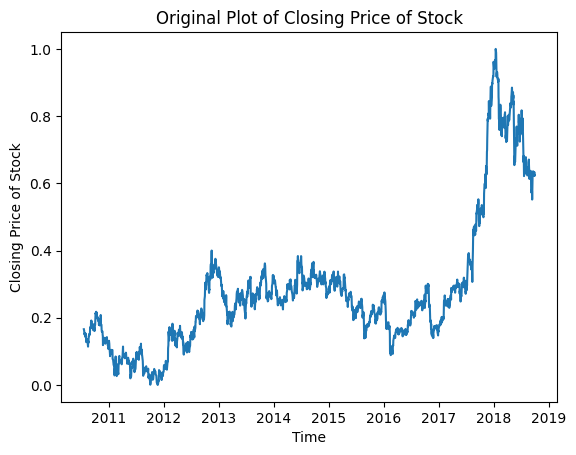

In [25]:
plt.plot(data.index,data['Close'])
plt.xlabel('Time')
plt.ylabel('Closing Price of Stock')
plt.title('Original Plot of Closing Price of Stock')

In [26]:
len(data),len(X_train),len(X_test),len(data.index[training_size+seq_len:])

(2035, 1374, 561, 561)

## *Performance of Model*

In [27]:
y_test_pred=minmaxscaler.inverse_transform(model_close.predict(X_test))

18/18 [==============================] - 2s 37ms/step


In [28]:
from sklearn.metrics import mean_squared_error
print("The Mean Squared Error Between Test Value and Predicted Value is: ",mean_squared_error(y_test,y_test_pred))
print("The Root Mean Squared Error Between Test Value and Predicted Value is: ",math.sqrt(mean_squared_error(y_test,y_test_pred)))

The Mean Squared Error Between Test Value and Predicted Value is:  41235.44504294261
The Root Mean Squared Error Between Test Value and Predicted Value is:  203.0651251272424


43/43 [==============================] - 2s 35ms/step


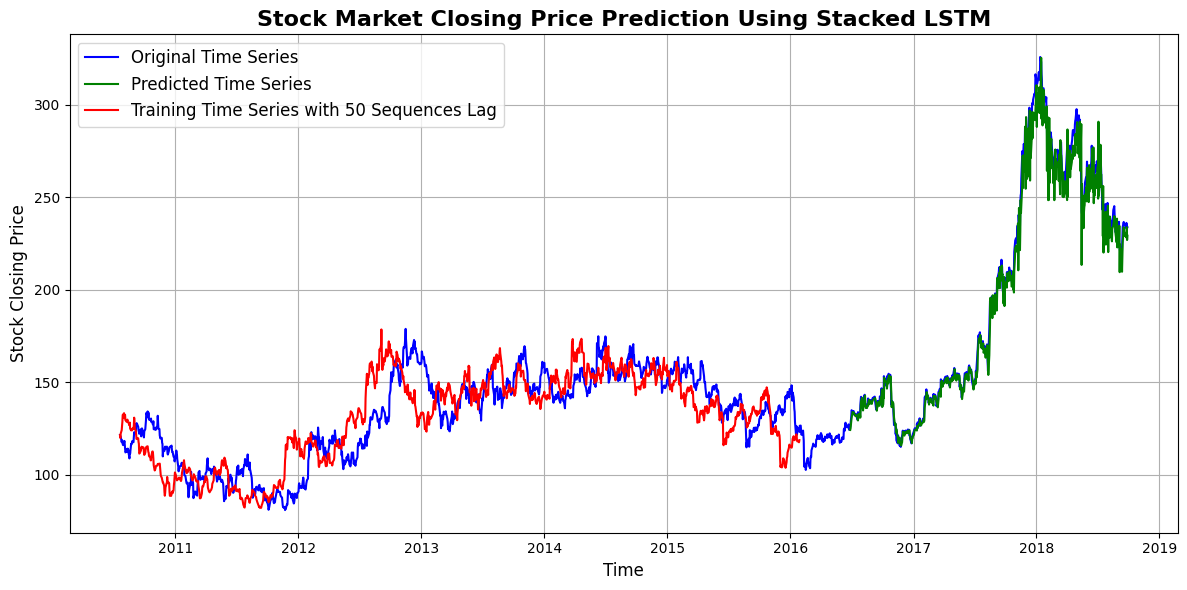

In [29]:
import matplotlib.pyplot as plt  # Correcting import statement

# Assuming data, X_train, X_test, model_close, minmaxscaler, and training_size are already defined

# Plotting the original time series, predicted time series, and training time series
plt.figure(figsize=(12, 6))
plt.plot(data.index, minmaxscaler.inverse_transform(data[['Close']]), label='Original Time Series', color='blue')
plt.plot(data.index[training_size + seq_len:], minmaxscaler.inverse_transform(model_close.predict(X_test)), label='Predicted Time Series', color='green')
plt.plot(data.index[:training_size - seq_len], minmaxscaler.inverse_transform(model_close.predict(X_train)), label='Training Time Series with {} Sequences Lag'.format(seq_len), color='red')

plt.xlabel('Time', fontsize=12)
plt.ylabel('Stock Closing Price', fontsize=12)
plt.title('Stock Market Closing Price Prediction Using Stacked LSTM', fontsize=16, weight='bold', ha='center')  # Adjusting title alignment
plt.legend(loc='upper left', fontsize=12)

# Adjusting layout to center the title and legends
plt.tight_layout()
plt.grid()
plt.show()


## *Conclusion*

*In conclusion, stock market prediction and forecasting using LSTM models offer significant insights and potential benefits in the investment landscape. By understanding and addressing complex stock price patterns and trends, the LSTM model can provide valuable predictions to guide investment decisions and risk management strategies. While the accuracy of LSTM models has proven promising, challenges remain in capturing long-term dependencies and non-linear relationships in stock price movements. Future research and improvements in model architecture, training methods, and data preprocessing will further enhance the effectiveness and reliability of these predictive models.*